# Udacity ML ND Capstone Project - Starbucks

The notebook contains following:
1. Overview of the Project
2. Dataset Review
3. Data Exploration and Cleaning

-------------------

## 1. Overview of the Project

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks.

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer.

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example
To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning
This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.


## 2. Dataset Review

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - 
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [1]:
#load the important libraries
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format ='retina'
pd.set_option('display.max_colwidth', -1)

In [2]:
#Read raw files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 3. Data Exploration and Cleaning

### 3.1 Portfolio

In [56]:
portfolio

,reward,channels,difficulty,duration,offer_type,id,name,web,email,mobile,social
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,bogo_10_10_7,0,1,1,1
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo_10_10_5,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,informational_0_0_4,1,1,1,0
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo_5_5_7,1,1,1,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount_20_5_10,1,1,0,0
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,discount_7_3_7,1,1,1,1
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,discount_10_2_10,1,1,1,1
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,informational_0_0_3,0,1,1,1
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,bogo_5_5_5,1,1,1,1
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,discount_10_2_7,1,1,1,0


#### The following preprocessing needs to be completed for the dataset
1. Combine offer details for more clarity as id does not show any details. The offer details will be combined as offer_type-difficulty-reward-duration
2. channels field need to be one hot encoded

In [25]:
#function for cleaning portfolio

def add_portfolio_name(portfolio_df):
    #provide portfolio name instead of id for interpretation later on

    portfolio_df['name'] = portfolio_df.offer_type.astype(str) + "_" + portfolio_df.difficulty.astype(str) +\
                      "_" + portfolio_df.reward.astype(str) + \
                     "_" + portfolio_df.duration.astype(str)
    return portfolio_df

def one_hot_channels(portfolio_df):
    #one hot encoded channels columns
    channels = ['web', 'email', 'mobile', 'social']

    for channel in channels:
        portfolio_df[channel] = portfolio_df.channels.apply(lambda x: channel in x)*1

    #drop channels column
    portfolio_df = portfolio_df.drop('channels', axis=1)
    
    return portfolio_df

def portfolio_preprocessing(portfolio_df):
    # portfolio preporcessing function, execute : add_portfolio_name and one_hot_channels
    
    portfolio_df = add_portfolio_name(portfolio_df)
    # one_hot_channels
    portfolio_df = one_hot_channels(portfolio_df)
    return portfolio_df

In [26]:
portfolio_clean = portfolio_preprocessing(portfolio)

In [28]:
portfolio

,reward,channels,difficulty,duration,offer_type,id,name,web,email,mobile,social
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,bogo_10_10_7,0,1,1,1
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo_10_10_5,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,informational_0_0_4,1,1,1,0
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo_5_5_7,1,1,1,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount_20_5_10,1,1,0,0
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,discount_7_3_7,1,1,1,1
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,discount_10_2_10,1,1,1,1
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,informational_0_0_3,0,1,1,1
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,bogo_5_5_5,1,1,1,1
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,discount_10_2_7,1,1,1,0


In [29]:
portfolio_clean

,reward,difficulty,duration,offer_type,id,name,web,email,mobile,social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,bogo_10_10_7,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo_10_10_5,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,informational_0_0_4,1,1,1,0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo_5_5_7,1,1,1,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount_20_5_10,1,1,0,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,discount_7_3_7,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,discount_10_2_10,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,informational_0_0_3,0,1,1,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,bogo_5_5_5,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,discount_10_2_7,1,1,1,0


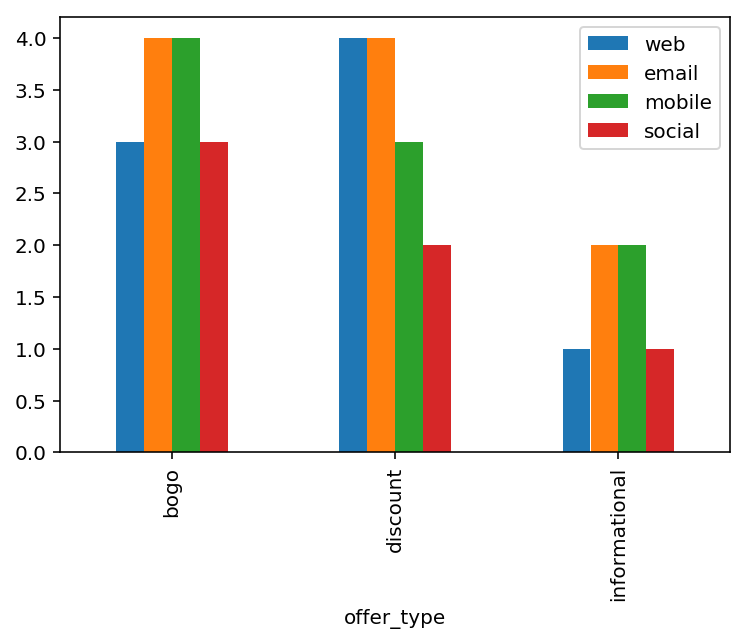

In [59]:
# offer type distribution by channels
channels = ['web', 'email', 'mobile', 'social']
portfolio_clean.groupby('offer_type').sum()[channels].plot(kind='bar')

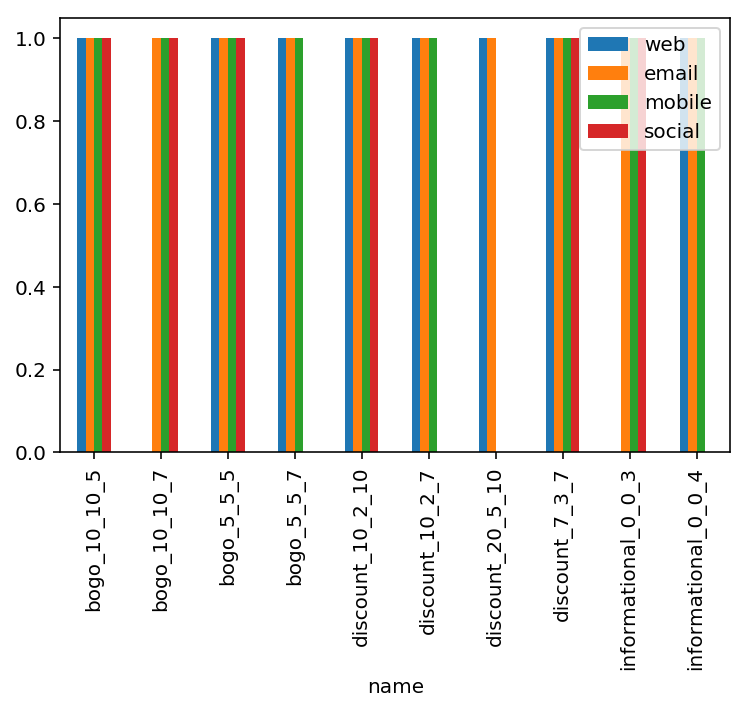

In [60]:
portfolio_clean.groupby('name').sum()[channels].plot(kind='bar')

### 3.2  Profile

In [31]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [32]:
profile.shape

(17000, 5)

In [34]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x124880588>,
      dtype=object)

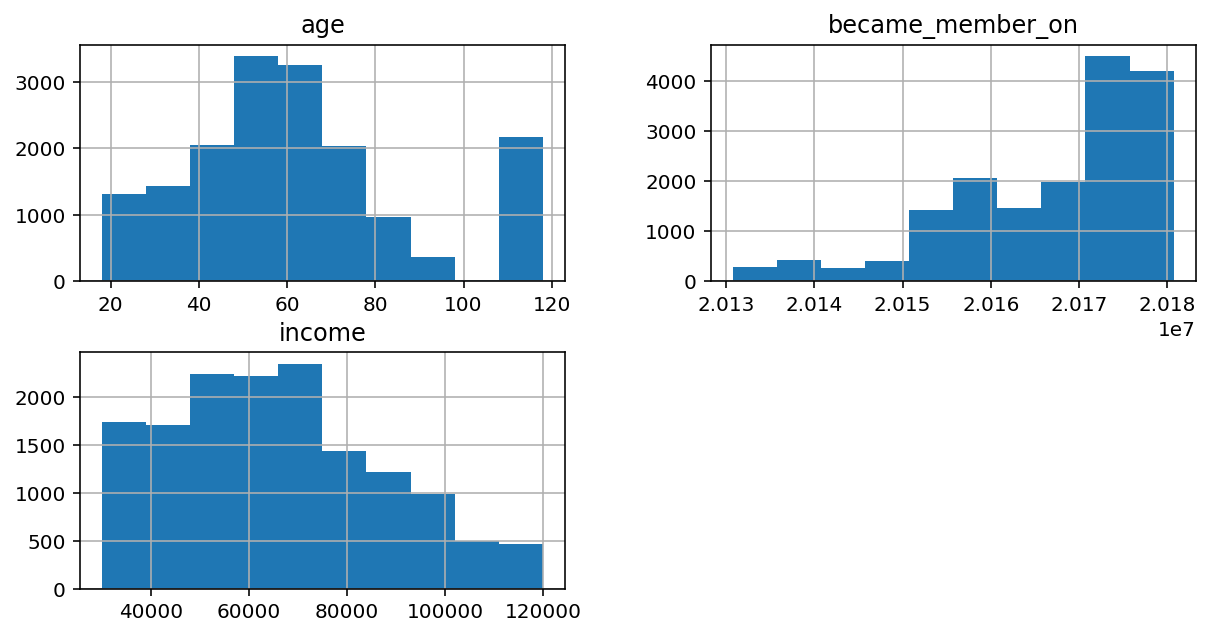

In [3]:
#distribution of age and income
profile[['age', 'income','became_member_on']].hist(figsize=(10,5))

#### Age more than 100 is unusual. This needs more investigation. 

In [36]:
profile[profile.age > 100].head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


#### It appears that age of 118 is a dummy field wherein people have not provided their gender and income information.

In [37]:
profile[profile.age == 118]['age'].value_counts()

118    2175
Name: age, dtype: int64

In [38]:
profile.isnull().sum()

gender              2175
age                 0   
id                  0   
became_member_on    0   
income              2175
dtype: int64

There are 2175 data with age of 118 and missing gender and income informations

In [41]:
profile['gender'].value_counts()

M    8484
F    6129
O    212 
Name: gender, dtype: int64

Apart from missing gender data group, there are three genders reported by users - Male, Female and Others (O)<br />

It is important to investigate income and age distributions for various gender classes

In [42]:
#statistics income by gender
profile.groupby('gender').describe()['income']

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
F,6129.0,71306.412139,22338.353773,30000.0,54000.0,71000.0,88000.0,120000.0
M,8484.0,61194.601603,20069.517615,30000.0,45000.0,59000.0,73000.0,120000.0
O,212.0,63287.735849,18938.594726,30000.0,51000.0,62000.0,79250.0,100000.0


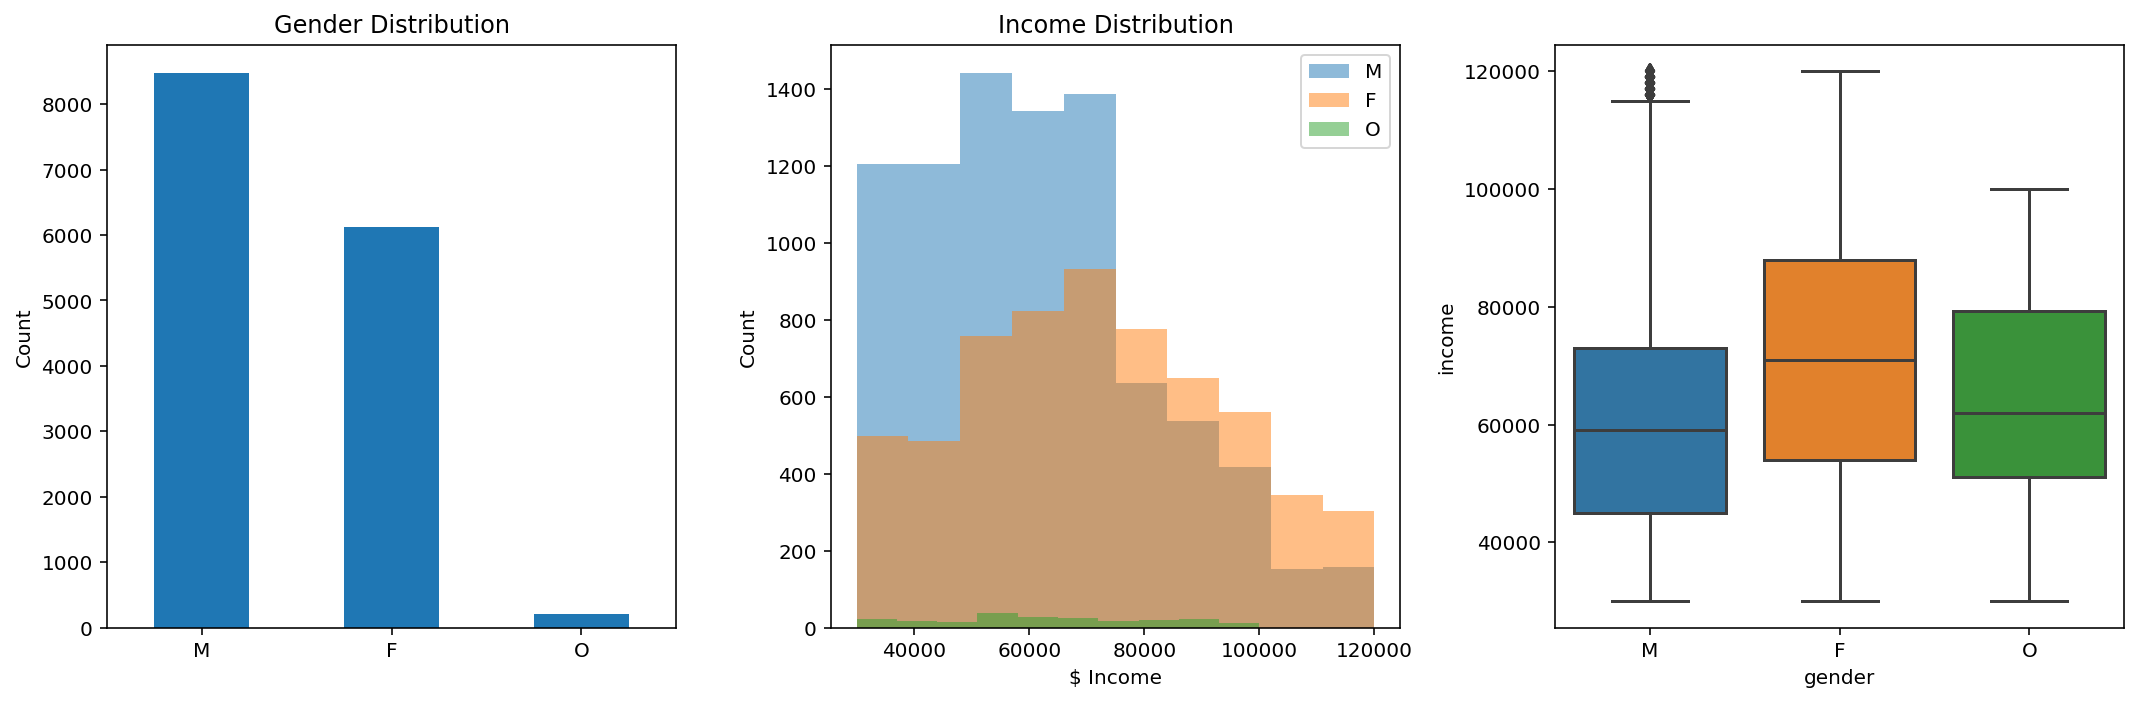

In [61]:
f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,5))

#plot gender distribution histogram
profile.gender.value_counts().plot(kind='bar', ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.set_title('Gender Distribution')
ax1.set_ylabel('Count')

# plot income distribution histogram
ax2.hist(profile[profile.gender == 'M']['income'], alpha=0.5, label='M')
ax2.hist(profile[profile.gender == 'F']['income'], alpha=0.5, label='F')
ax2.hist(profile[profile.gender == 'O']['income'], alpha=0.5, label='O')
ax2.set_xlabel('$ Income')
ax2.set_ylabel('Count')
ax2.set_title('Income Distribution')
ax2.legend()
# boxplot income distribution
sns.boxplot('gender', 'income', data=profile, ax=ax3, order=['M', 'F', 'O'])
plt.tight_layout()

#### Gender Statistics
- Most of customers are males (50%) then followed by females (36%) and  other gender (1.25%)
- the average income of females (71306 dollars) are higher than males (61194 dollars) and other gender (63287 dollars).
- There are other gender denoted as 'o'

### The became_member_on field is in integers. It needs to be parsed into data format

In [7]:
#parse dates in became_member_on column

def profile_parse_dates(profile_df):
    profile_df = profile_df.copy()

    #convert to string
    profile_df['became_member_on'] = profile_df.became_member_on.apply(lambda x: str(x))
    #convert to datetime format
    profile_df['became_member_on'] = pd.to_datetime(profile_df.became_member_on)
    return profile_df

profile_clean = profile_parse_dates(profile)

In [8]:
profile_clean.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


In [44]:
#profile['year'] = profile['became_member_on'].apply(lambda x:int(str(x)[0:4]))  # extract year, month and date of membership
#profile['month'] = profile['became_member_on'].apply(lambda x:int(str(x)[4:6]))
#profile['day'] = profile['became_member_on'].apply(lambda x:int(str(x)[-2:]))

In [45]:
profile.head()

,gender,age,id,became_member_on,income,year,month,day
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,2017,2,12
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,2017,7,15
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,2018,7,12
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017,5,9
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,2017,8,4


Text(0.5, 1.0, 'Distribution of became_member_on')

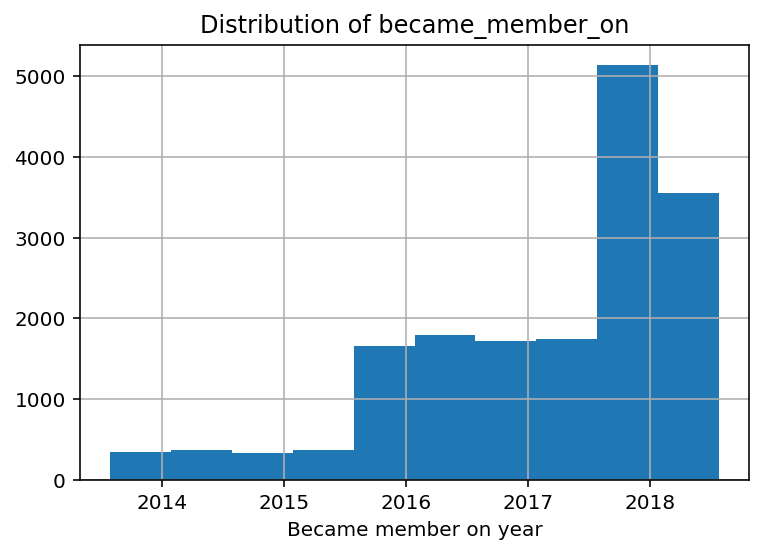

In [9]:
profile_clean.became_member_on.hist()
plt.xlabel('Became member on year')
plt.title('Distribution of became_member_on')

#### Missing Values

In [10]:
profile_clean.isnull().sum()

gender              2175
age                 0   
id                  0   
became_member_on    0   
income              2175
dtype: int64

There are 2175 rows with missing data values in income and gender columns <br />

It is worthwhile to compare distributions with missing and non-missing data

In [11]:
# How much data is missing in each row of profiile  dataset?
row_null = profile_clean.isnull().sum(axis=1)
row_null.value_counts()

0    14825
2    2175 
dtype: int64

In [13]:
row_null.head()

0    2
1    0
2    2
3    0
4    2
dtype: int64

In [16]:
profile_notnull = profile[row_null ==0]
profile_null = profile[row_null > 0]

In [17]:
profile_null.shape

(2175, 5)

In [18]:
profile_notnull.shape

(14825, 5)

### 3.3  Transcript

In [58]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [59]:
transcript.shape

(306534, 4)

In [60]:
transcript.tail()

,person,event,value,time
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,{'amount': 4.05},714


In [61]:
transcript['event'].value_counts()

transaction        138953
offer received     76277 
offer viewed       57725 
offer completed    33579 
Name: event, dtype: int64

In [63]:
#check for missing values
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [68]:
transcript['person'].nunique()

17000

#### We need to deconstruct value column into offer_id and amount columns. The offer id and offer_id are same but incorrectly labelled as different. 

In [21]:
""" Encode offer_id and amount in value column """

def encode_offer_id(x):
    try :
        return x['offer id']
    except:
        return x['offer_id']

def transcript_encoded(transcript_df):
    transcript_encoded = transcript_df.copy()
    transcript_encoded['offer_id'] = transcript[transcript.event.isin(['offer received', 'offer viewed', 'offer completed'])]\
                                                             .value.apply(encode_offer_id)
    transcript_encoded['amount'] =  transcript[transcript.event.isin(['transaction'])].value.apply(lambda x: x['amount'])
    return transcript_encoded

transcript_encoded(transcript).head()

,person,event,value,time,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [22]:
transcript_encoded(transcript).tail()

,person,event,value,time,offer_id,amount
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,NaN,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,NaN,9.53
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,NaN,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,NaN,3.53
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,{'amount': 4.05},714,NaN,4.05


In [30]:
""" join profile,portfolio and transcript datasets """

def merge_transcript_profile(transcript_df, profile_df):
    profile_df = profile_parse_dates(profile_df)
    transcript_encoded_df = transcript_encoded(transcript_df)
    transcript_profile_df = pd.merge(transcript_encoded_df, profile_df, left_on=['person'], 
                                      right_on = ['id'], how ='left')
    transcript_profile_df = transcript_profile_df.drop(['id'], axis=1)
    
    return transcript_profile_df


def merge_transcript_profile_portfolio(transcript_df, profile_df, portfolio_df):
    portfolio_df = portfolio_preprocessing(portfolio_df)
    transcript_profile_df = merge_transcript_profile(transcript_df, profile_df)
    transcript_profile_porto = pd.merge(transcript_profile_df, portfolio_df, left_on = 'offer_id', right_on ='id', how='left').drop('id', axis=1)
    return transcript_profile_porto


data_merged = merge_transcript_profile_portfolio(transcript, profile, portfolio)
data_merged.head()

,person,event,value,time,offer_id,amount,gender,age,became_member_on,income,reward,difficulty,duration,offer_type,name,web,email,mobile,social
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,2017-05-09,100000.0,5.0,5.0,7.0,bogo,bogo_5_5_7,1.0,1.0,1.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,None,118,2017-08-04,NaN,5.0,20.0,10.0,discount,discount_20_5_10,1.0,1.0,0.0,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,M,68,2018-04-26,70000.0,2.0,10.0,7.0,discount,discount_10_2_7,1.0,1.0,1.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,None,118,2017-09-25,NaN,2.0,10.0,10.0,discount,discount_10_2_10,1.0,1.0,1.0,1.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,None,118,2017-10-02,NaN,10.0,10.0,5.0,bogo,bogo_10_10_5,1.0,1.0,1.0,1.0


In [31]:
  data_merged.shape

(306534, 19)

## Analyzing data distribution

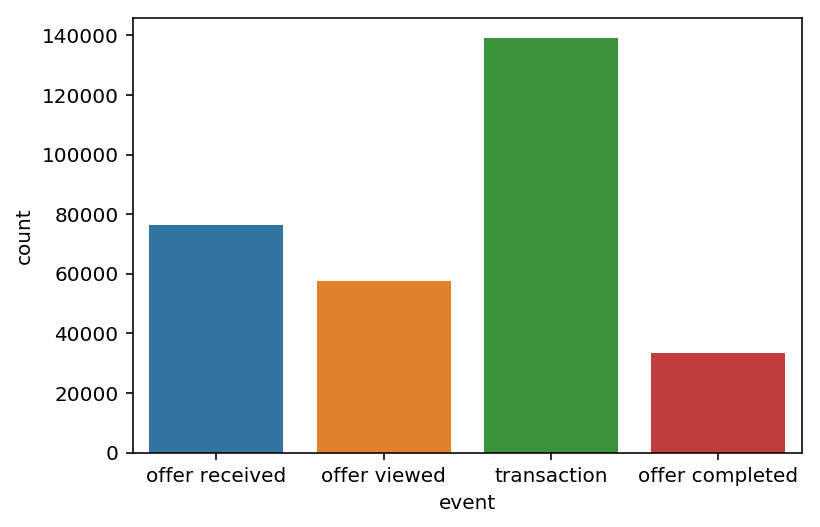

In [33]:
""" transcript event type distribution """

sns.countplot('event', data= data_merged)

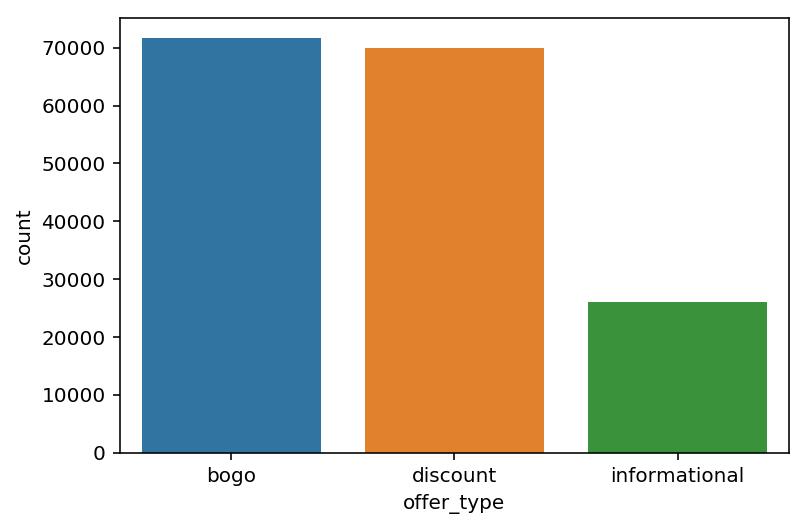

In [81]:
""" offer type distribution """
sns.countplot('offer_type', data= data_merged)

Text(0.5, 1.0, 'Offers sent to customers')

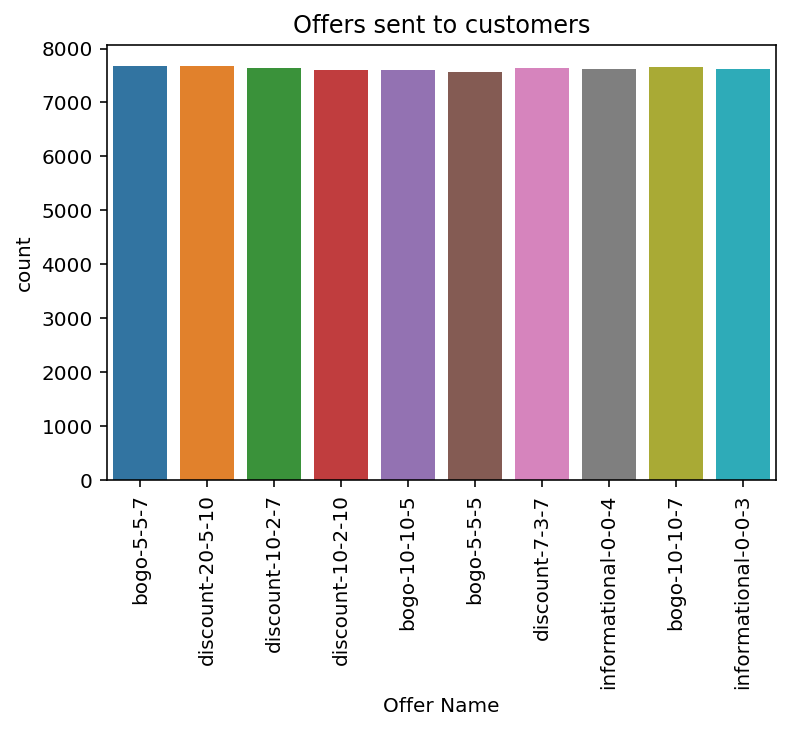

In [83]:
""" The distribuiton of offer sent to customers """

received = data_merged[data_merged.event =='offer received']
sns.countplot(received['name'])
plt.xlabel('Offer Name')
plt.xticks(rotation=90)
plt.title('Offers sent to customers')

#### The distribution of typr of  offers sent by Starbucks is uniform

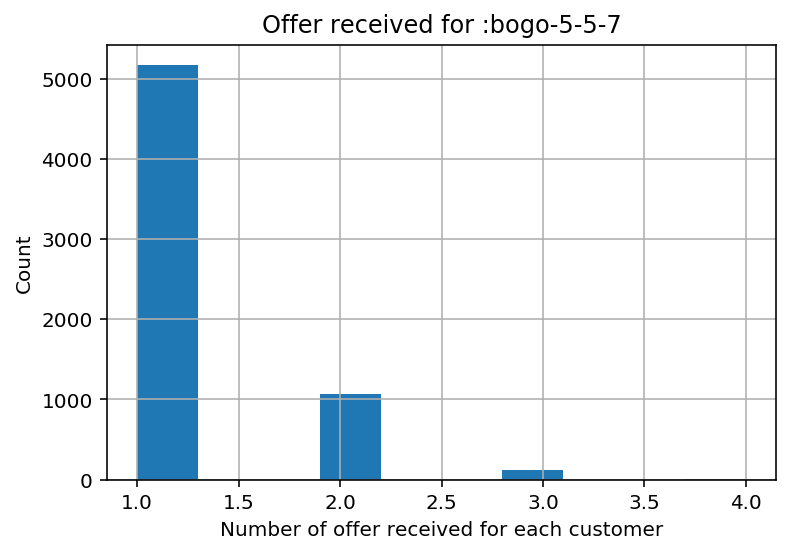

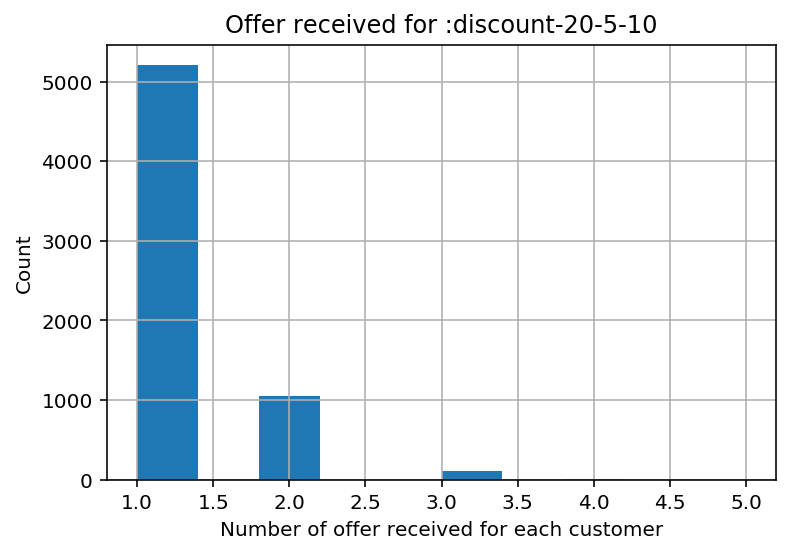

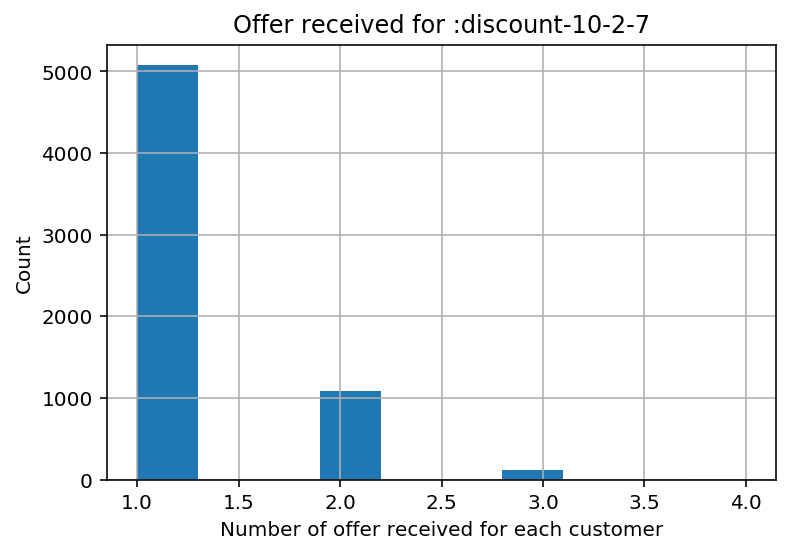

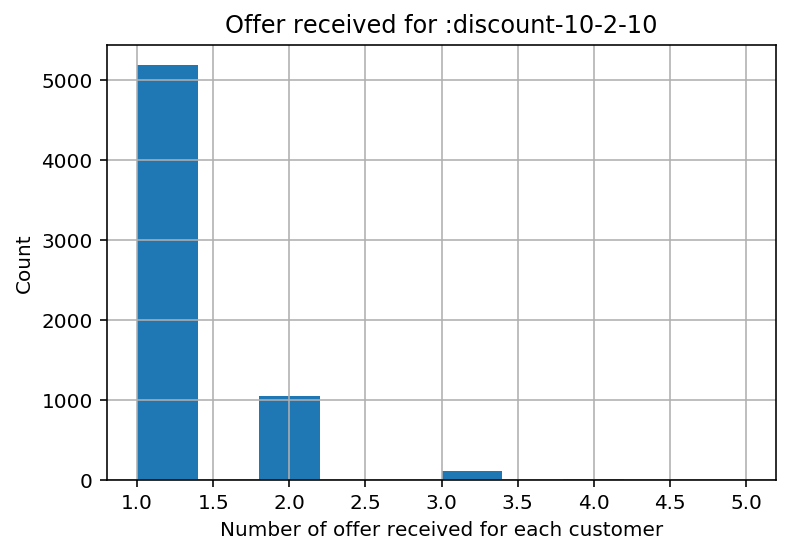

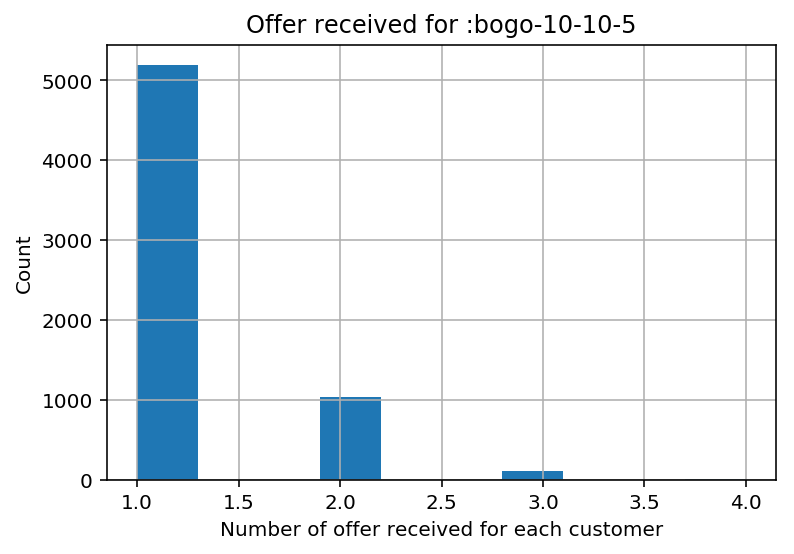

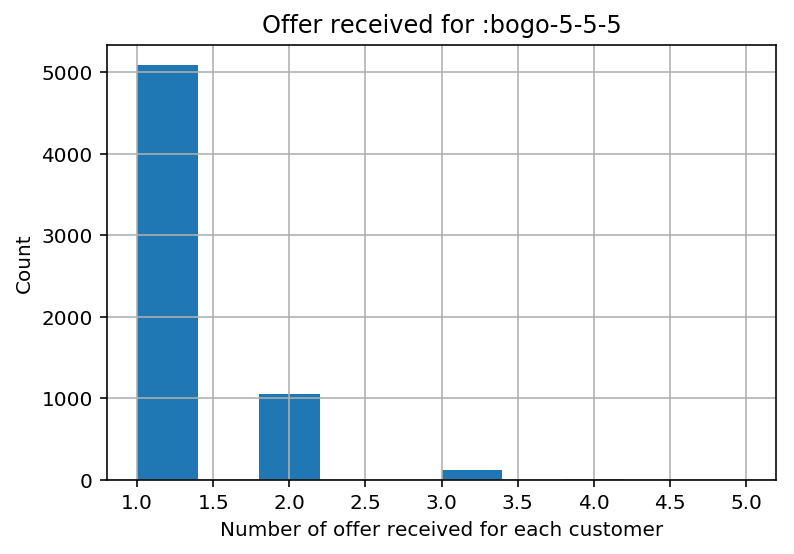

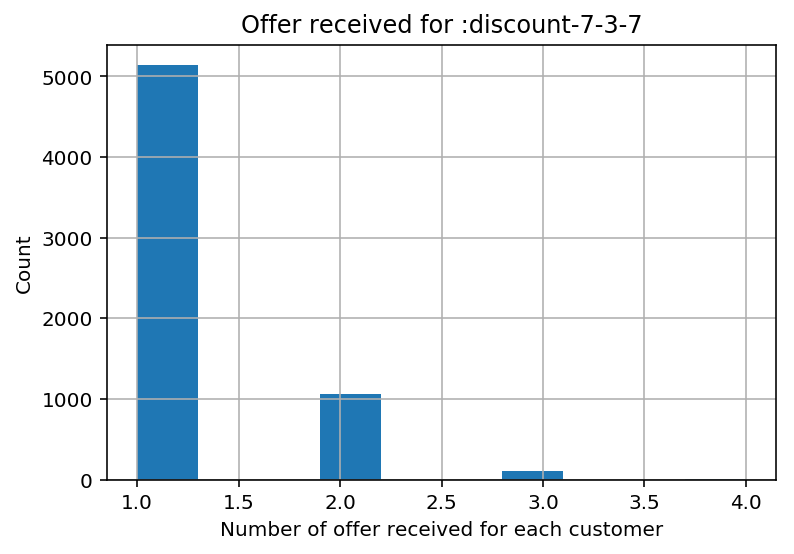

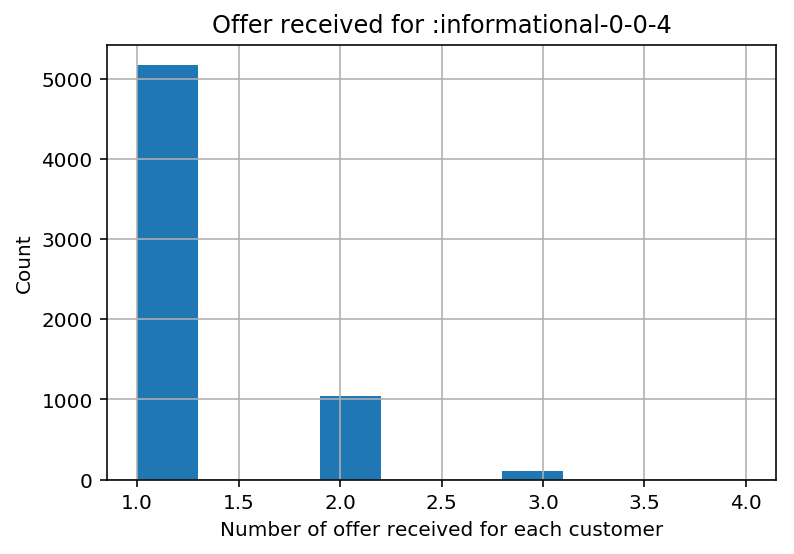

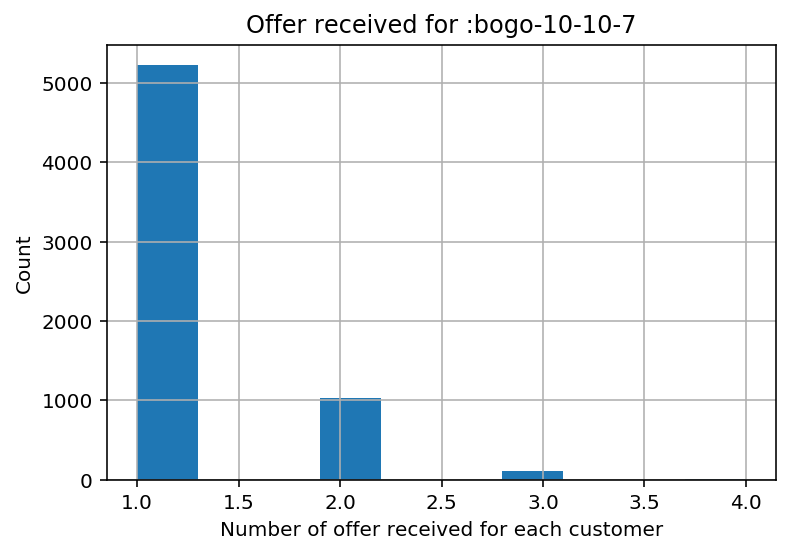

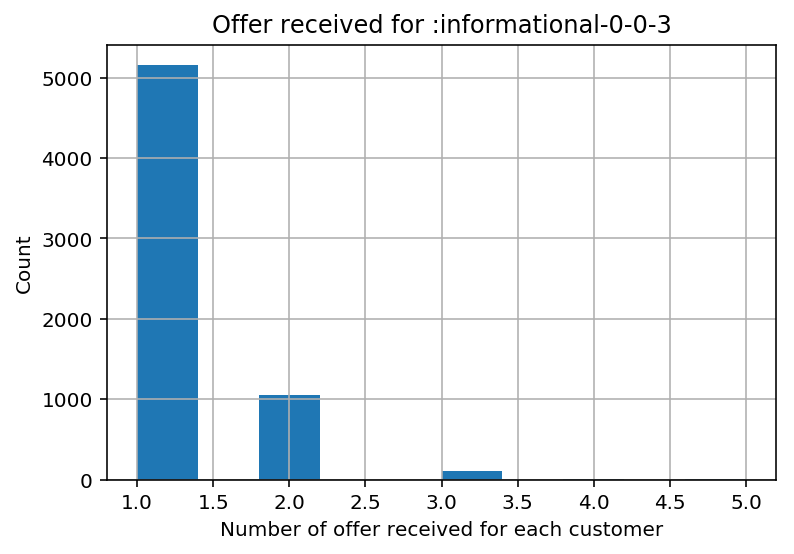

In [84]:
""" The distribution of offer received for each customer (profile) """

for offer_name in received.name.unique():
    received[received.name == offer_name]['person'].value_counts().hist()
    plt.xlabel('Number of offer received for each customer')
    plt.ylabel('Count')
    plt.title('Offer received for :' + offer_name)
    plt.show()


#### Most customers have received a particular offer once, however some have received offer more than once

### Spending and Transactions details

count    16578.000000
mean     13.680266   
std      16.056763   
min      0.050000    
25%      3.181392    
50%      11.996607   
75%      20.469643   
max      451.470000  
Name: amount, dtype: float64

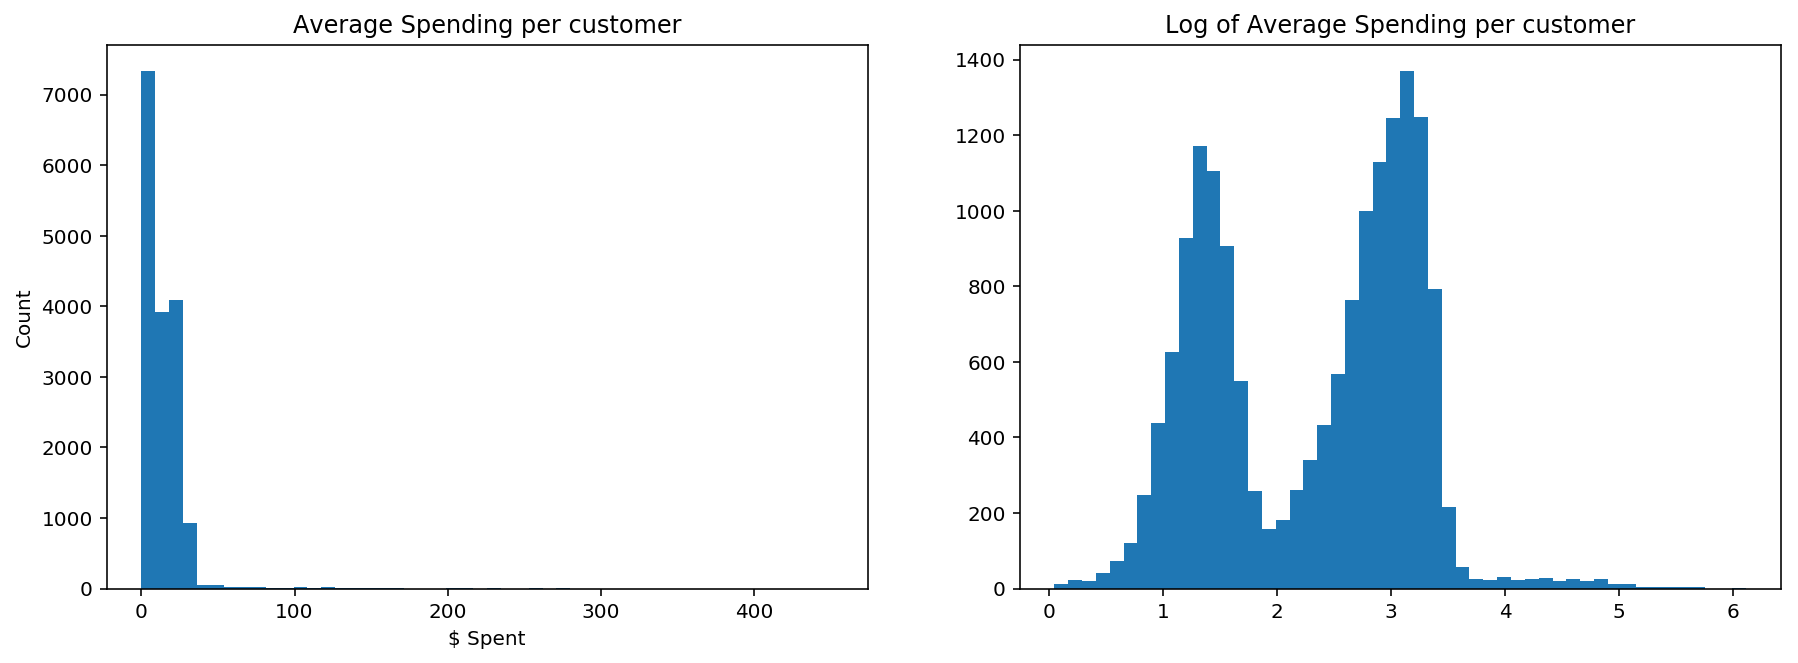

In [48]:
""" Average Spending distribution for each customer """
f, (ax1,ax2) = plt.subplots(1,2,figsize = (15,5))
avg_spending = data_merged.groupby('person')['amount'].mean()
ax1.hist(avg_spending,bins = 50)
ax1.set_xlabel('$ Spent')
ax1.set_ylabel('Count')
ax1.set_title('Average Spending per customer')

ax2.hist(np.log(1+avg_spending),bins = 50)
ax2.set_title('Log of Average Spending per customer')
data_merged.groupby('person')['amount'].mean().describe()

count    17000.000000
mean     104.438351  
std      125.922619  
min      0.000000    
25%      21.820000   
50%      69.405000   
75%      148.782500  
max      1608.690000 
Name: amount, dtype: float64

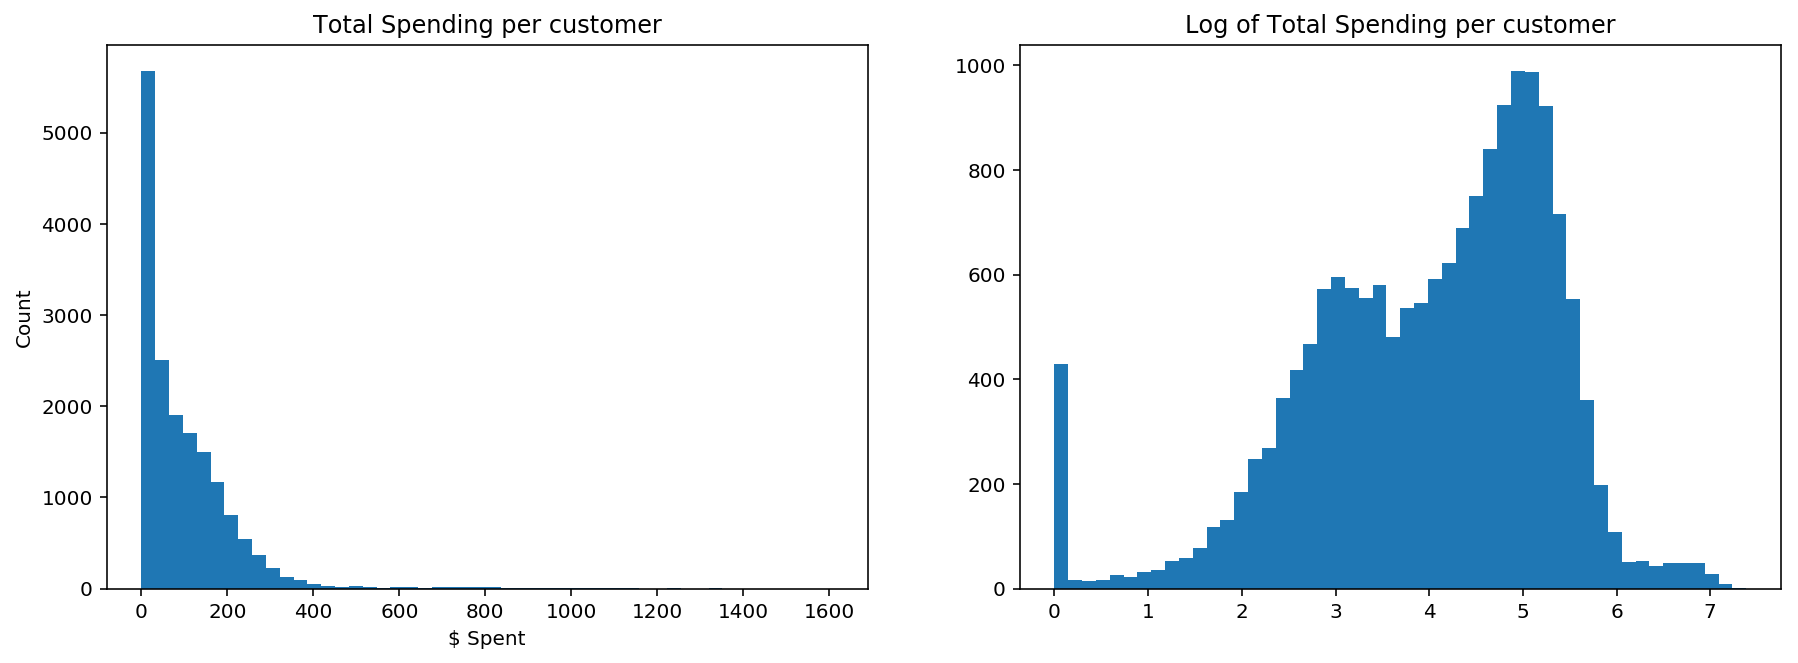

In [49]:
""" Total Spending distribution for each customer """
f, (ax1,ax2) = plt.subplots(1,2,figsize = (15,5))
total_spending = data_merged.groupby('person')['amount'].sum()
ax1.hist(total_spending,bins = 50)
ax1.set_xlabel('$ Spent')
ax1.set_ylabel('Count')
ax1.set_title('Total Spending per customer')

ax2.hist(np.log(1+total_spending),bins = 50)
ax2.set_title('Log of Total Spending per customer')
data_merged.groupby('person')['amount'].sum().describe()

### The average and total spending are log normally distributed as can be seen from above figures

count    17000.000000
mean     8.173706    
std      5.116250    
min      0.000000    
25%      4.000000    
50%      7.000000    
75%      11.000000   
max      36.000000   
Name: amount, dtype: float64

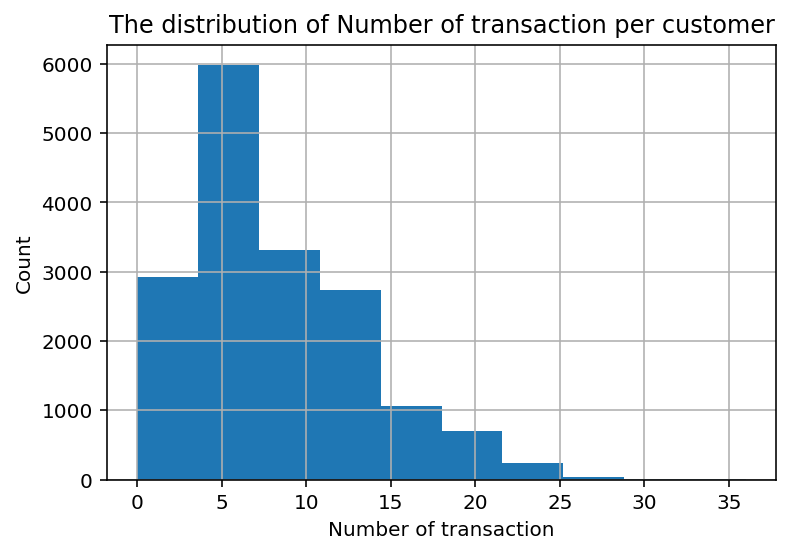

In [50]:
""" The distribution of transaction count for each customer """
data_merged.groupby('person')['amount'].count().hist()
plt.xlabel('Number of transaction')
plt.ylabel('Count')
plt.title('The distribution of Number of transaction per customer')
data_merged.groupby('person')['amount'].count().describe()

Text(0.5, 0, 'gender')

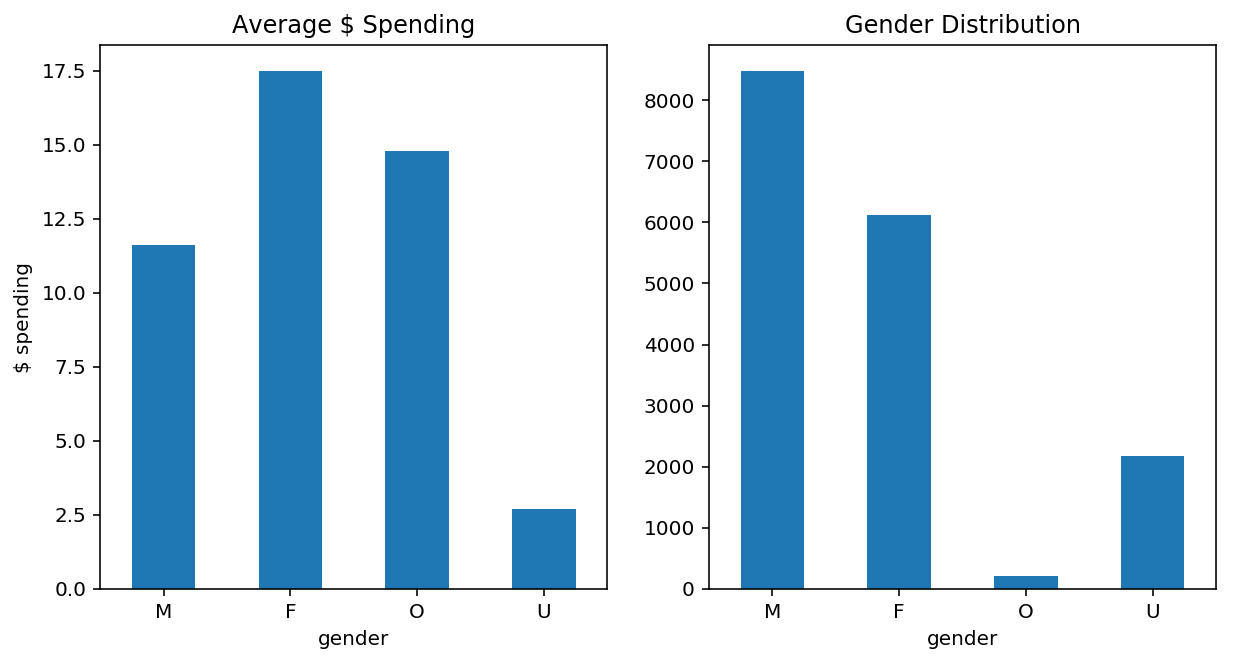

In [51]:
""" Average spending by GENDER """

# assign missing value in gender with 'U' value
data_merged_ = data_merged.copy()
data_merged_.loc[data_merged.gender.isnull(), 'gender'] ='U'

#plot
f, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

#plot average spending
data_merged_.groupby('gender')['amount'].mean()[['M', 'F', 'O', 'U']].plot(kind='bar', ax=ax1);
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.set_ylabel("$ spending")
ax1.set_title("Average $ Spending");

#plot gender distribution
profile.fillna('U').gender.value_counts()[['M', 'F', 'O', 'U']].plot(kind='bar', ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
plt.title('Gender Distribution');
ax2.set_xlabel('gender')

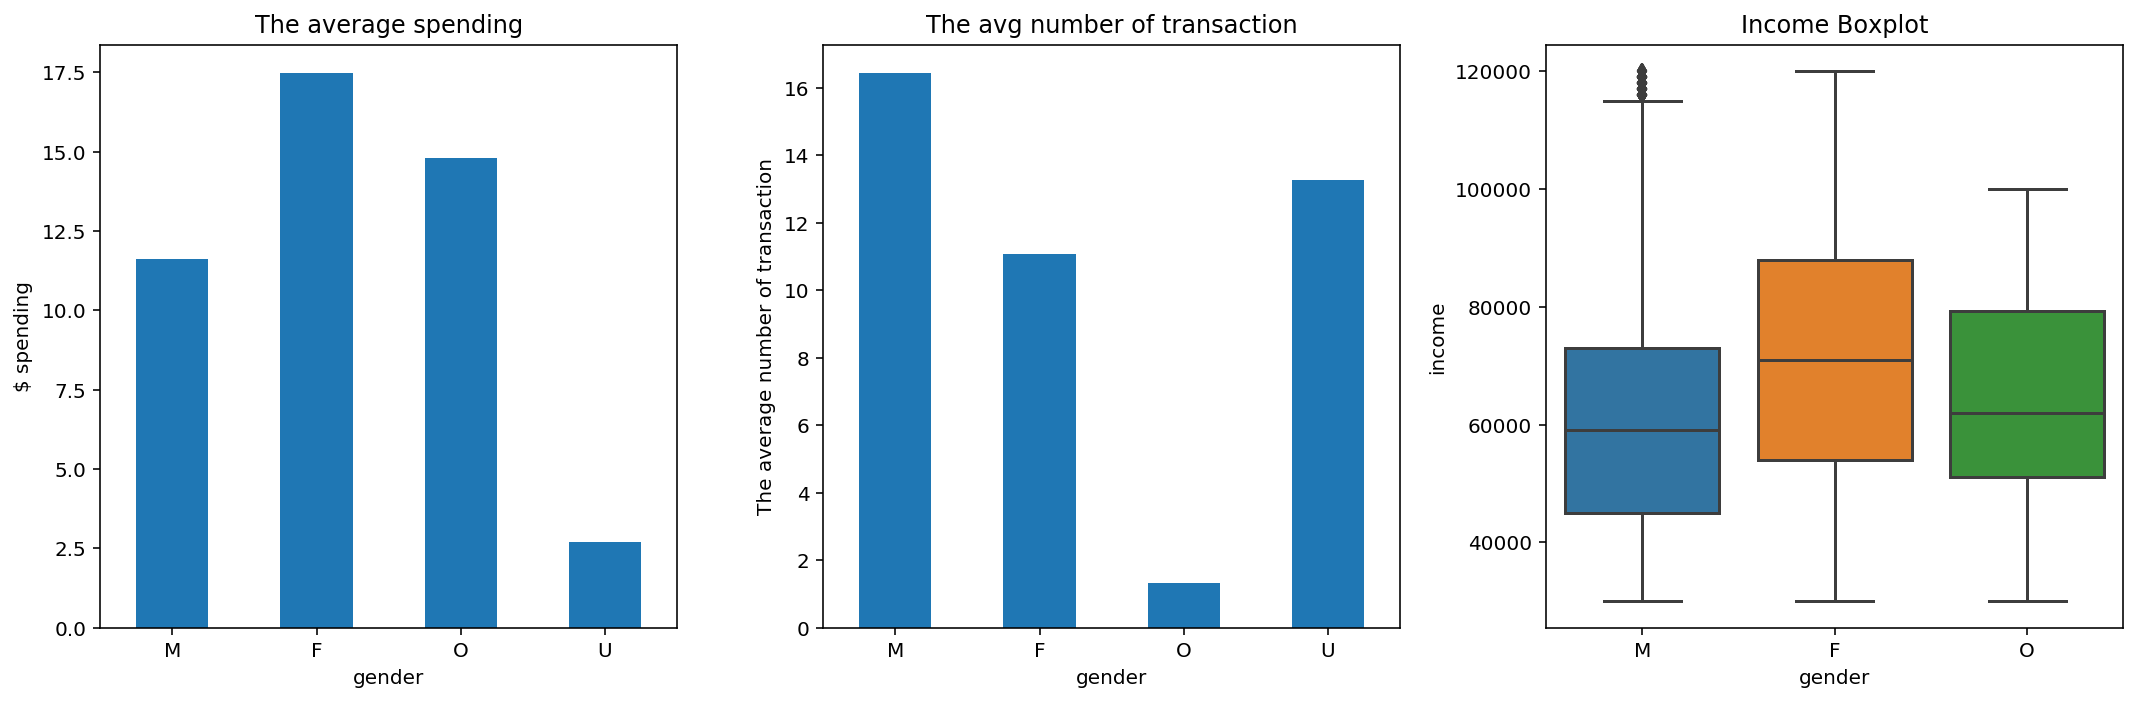

In [52]:
""" The number of transaction by GENDER """

#plot avg spending
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
data_merged_.groupby('gender')['amount'].mean()[['M', 'F', 'O', 'U']].plot(kind='bar', ax=ax1);
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.set_ylabel("$ spending")
ax1.set_title('The average spending')

# plot avg number of transactiond
data_merged_.groupby(['gender', 'amount'])['amount'].count().mean(level=0)[['M', 'F', 'O', 'U']].plot(kind='bar', ax=ax2);
ax2.set_xticklabels(ax1.get_xticklabels(), rotation=0);
ax2.set_ylabel("The average number of transaction");
ax2.set_title("The avg number of transaction");

# boxplot income distribution
sns.boxplot('gender', 'income', data=profile, ax=ax3, order=['M', 'F', 'O'])
ax3.set_title('Income Boxplot')

plt.tight_layout()

#### The highest average spending is made by females, while males made most transactions. The unspecified gender category made more transactions than Female and others, although their average spending was the least of all genders

### Offer received, viewed and completed

Text(0.5, 1.0, 'Portfolio Distribution by Event')

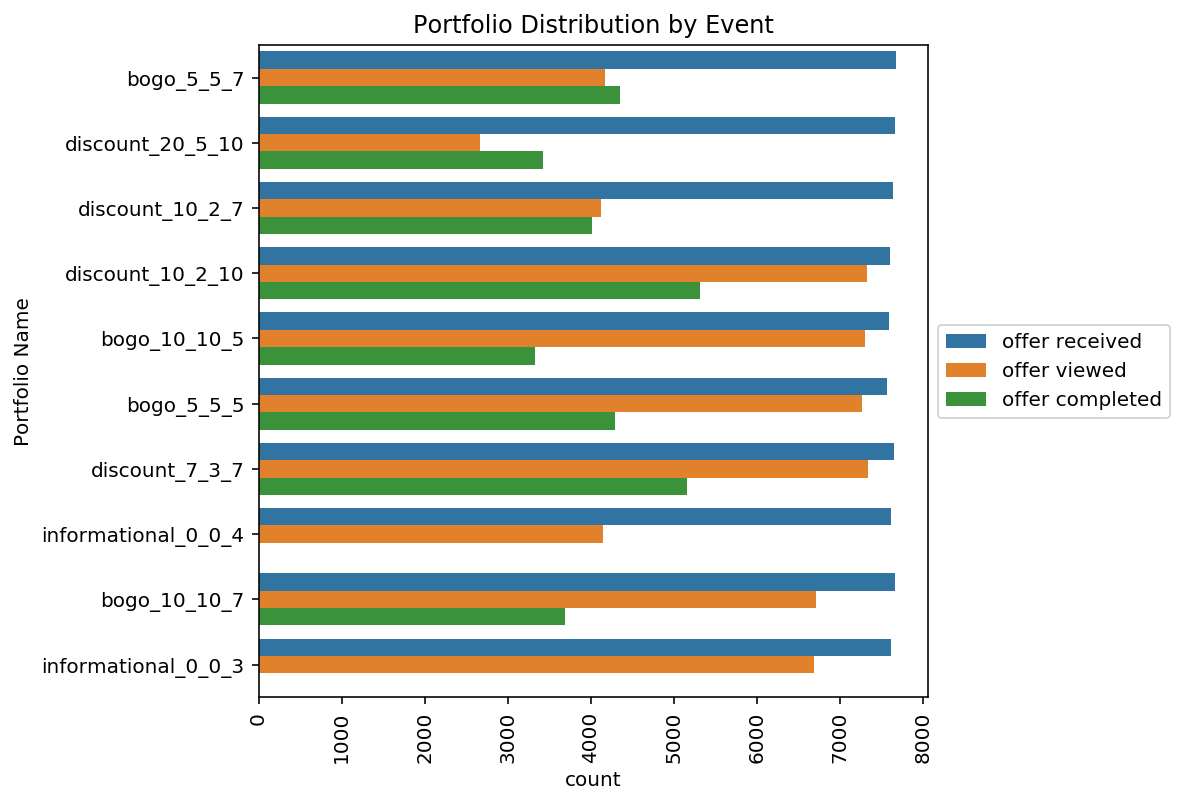

In [53]:
"""
Portfolio Distribution by event
"""
plt.figure(figsize=(6,6))
sns.countplot(y='name', hue='event', data=data_merged[~data_merged.event.isin(['transaction'])]);
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=90)
plt.ylabel("Portfolio Name")
plt.title("Portfolio Distribution by Event")

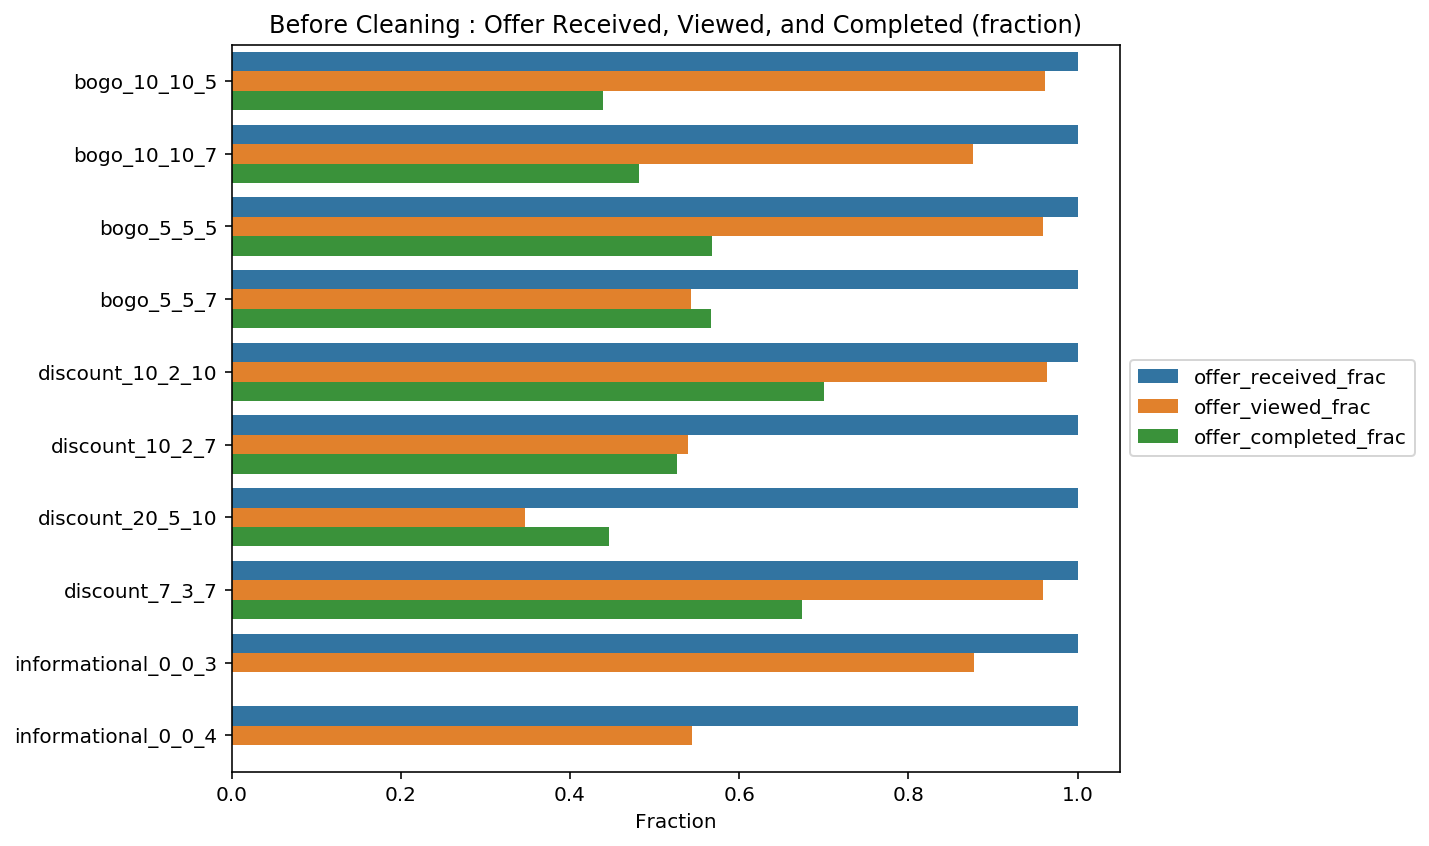

In [55]:
""" Portfolio Distribution by event in Fraction """

event_count = data_merged[~data_merged.event.isin(['transaction'])].groupby(['name', 'event']).size().unstack()
event_count['offer_received_frac'] = event_count['offer received']/ event_count['offer received']
event_count['offer_viewed_frac'] = event_count['offer viewed']/ event_count['offer received']
event_count['offer_completed_frac'] =  event_count['offer completed']/ event_count['offer received']

event_count_frac = event_count[['offer_received_frac','offer_viewed_frac', 'offer_completed_frac']]

event_count_stack = event_count_frac.stack().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x=0,y='name', hue='event', data=event_count_stack)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplots_adjust(top=0.8)
plt.title("Before Cleaning : Offer Received, Viewed, and Completed (fraction)")
plt.ylabel('')
plt.xlabel('Fraction')

plt.tight_layout()

 `Bogo 5_5_7` and `Discount_20_5_10` have higher offer completion rate than offer viewed. It means that the transaction was not due to the offer and requires to be separated for further analysis